# Dry Weather Flow Analysis


In this post, I am going to go through the exercieses of [EPA SSOAP](https://www.epa.gov/water-research/sanitary-sewer-overflow-analysis-and-planning-ssoap-toolbox) using python.

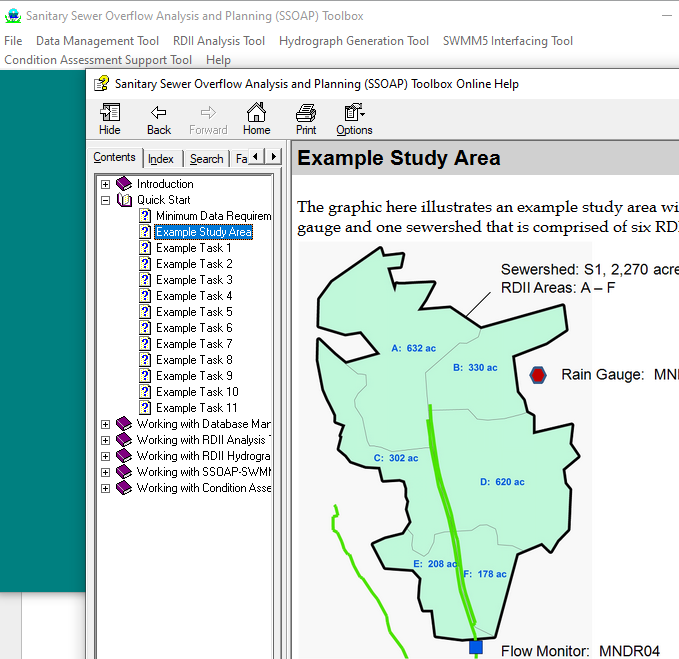

## Read the csv files

Using the code below to read the flow and rainfall data from the csv file.

Both the flow data and rainfall data are 15 min interval, and the rainfall is in total depth format. 

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
def read_flow_csv(f):
    df = pd.read_csv(f)
    df.index = df.apply(lambda x: datetime.datetime(int(x['Year']), int(x['Month']), int(x['Day']), int(x['Hour']), int(x['Minute'])), axis=1)
    
    return df.loc[:, ['Flow_mgd', 'Velocity_fps', 'Depth_in']]


def read_rain_csv(f):
    df = pd.read_csv(f)
    df.index = df.apply(lambda x: datetime.datetime(int(x['Year']), int(x['Month']), int(x['Day']), int(x['Hour']), int(x['Minute'])), axis=1)
    
    return df.loc[:, ['Rain (inch)']]

## Interactively Plot the Data

Using the powerful [plotly](https://plotly.com/python/) libraries, we can create interactive plots fairly easily. You can find more about how to set it up in my [medium post](https://medium.com/@mel.meng.pe/big-data-brings-advanced-graphing-tools-to-everyone-e5734038b604). Below are a few helper functions to plot the data.


In [2]:
import pandas as pd
import csv
import plotly.graph_objects as go

In [3]:
def scatter_plot(df, depth_fld, velocity_fld, depth_unit='in', velocity_unit='fps'):
    # https://github.com/plotly/plotly.py/issues/1445

    df = df.copy()
    df._velocity = df[velocity_fld]
    df._depth = df[depth_fld]
    fig = go.FigureWidget()
    trace1 = fig.add_scattergl(x=df._velocity, y=df._depth, mode='markers', name='points',
                             marker = dict(size=5,
                                           opacity=.5,
                                           color='#1f77b4',
                                           line = dict(width=1, color = '#1f77b4')
                                          )
                            )
    trace2 = fig.add_histogram(x=df._velocity, name='velocity', marker=dict(color='#1f77b4', opacity=0.7),
                          yaxis='y2'
                         )
    trace3 = fig.add_histogram(y=df._depth, name='depth', marker=dict(color='#1f77b4', opacity=0.7), 
                          xaxis='x2'
                         )
    fig.layout = dict(xaxis=dict(domain=[0, 0.85], showgrid=True, zeroline=False, title='Velocity(%s)' % velocity_unit),
                      yaxis=dict(domain=[0, 0.85], showgrid=True, zeroline=False, title='Depth(%s)' % depth_unit),
                      showlegend=False,
                      margin=dict(t=50),
                      hovermode='closest',
                      bargap=0,
                      xaxis2=dict(domain=[0.85, 1], showgrid=False, zeroline=False),
                      yaxis2=dict(domain=[0.85, 1], showgrid=False, zeroline=False),
                      height=600,
                      width=600,
                      title = 'Scatter Plot'
                     )

    def do_zoom(layout, xaxis_range, yaxis_range):
        inds = ((xaxis_range[0] <= flow.df._velocity) & (flow.df._velocity <= xaxis_range[1]) &
                (yaxis_range[0] <= flow.df._depth) & (flow.df._depth <= yaxis_range[1]))

        with fig.batch_update():
            trace2.x = flow.df._velocity[inds]
            trace3.y = flow.df._depth[inds]

    fig.layout.on_change(do_zoom, 'xaxis.range', 'yaxis.range')
    return fig

In [4]:
from plotly.subplots import make_subplots

def flow_plot(flow_df, rain_df, depth_fld, velocity_fld, rainfall_fld, flow_fld, depth_unit='in', 
              rainfall_unit='in/hr', flow_unit='mgd', velocity_unit='fps', start=None, end=None):
    
    rain_df = rain_df.copy()
    flow_df = flow_df.copy()
    if start:
        rain_df = rain_df[start:end]  
        flow_df = flow_df[start:end]
        
    rain_df['_rainfall'] = rain_df[rainfall_fld]
    flow_df['_flow'] = flow_df[flow_fld]
    flow_df['_depth'] = flow_df[depth_fld]
    flow_df['_velocity'] = flow_df[velocity_fld]
    fig = make_subplots(rows=3, cols=1, 
                        shared_xaxes=True, 
                        vertical_spacing=0.01,
                       row_heights=[0.2,0.4,0.4],
                       specs=[[{"secondary_y": False}],[{"secondary_y": True}], [{"secondary_y": False}]])

    fig.add_trace(go.Scatter(
        x = rain_df.index,
        y = rain_df['_rainfall'],
        name = 'rainfall',
        line_shape='hv',
        fill='tozeroy',
        line=dict(color='blue', width=1)

    ) , row=1, col=1)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._depth,
        name = 'Depth',
        line=dict(color='blue')
    ) , row=2, col=1)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._velocity,
        name = 'Velocity',
        line=dict(color='green', dash='dot')

    ) , row=2, col=1, secondary_y=True)

    fig.add_trace(go.Scatter(
        x = flow_df.index,
        y = flow_df._flow,
        name = 'flow',
        line=dict(color='blue')
    ) , row=3, col=1)

    fig['layout']['yaxis1'].update(autorange="reversed", 
                                   title='Rainfall (%s)' % rainfall_fld)

    fig['layout']['yaxis2'].update(title='Depth(%s)' % depth_unit)
    fig['layout']['yaxis3'].update(title='Velocity(%s)' % velocity_unit)
    fig['layout']['yaxis4'].update(title='Flow(%s)' % flow_unit)




    fig.update_layout(
        height = 800, width=1200,
                      title_text="Flow Data Plot",
                     xaxis3_rangeslider_visible=True, 
                      xaxis3_rangeslider_thickness=0.1)
    
    return fig

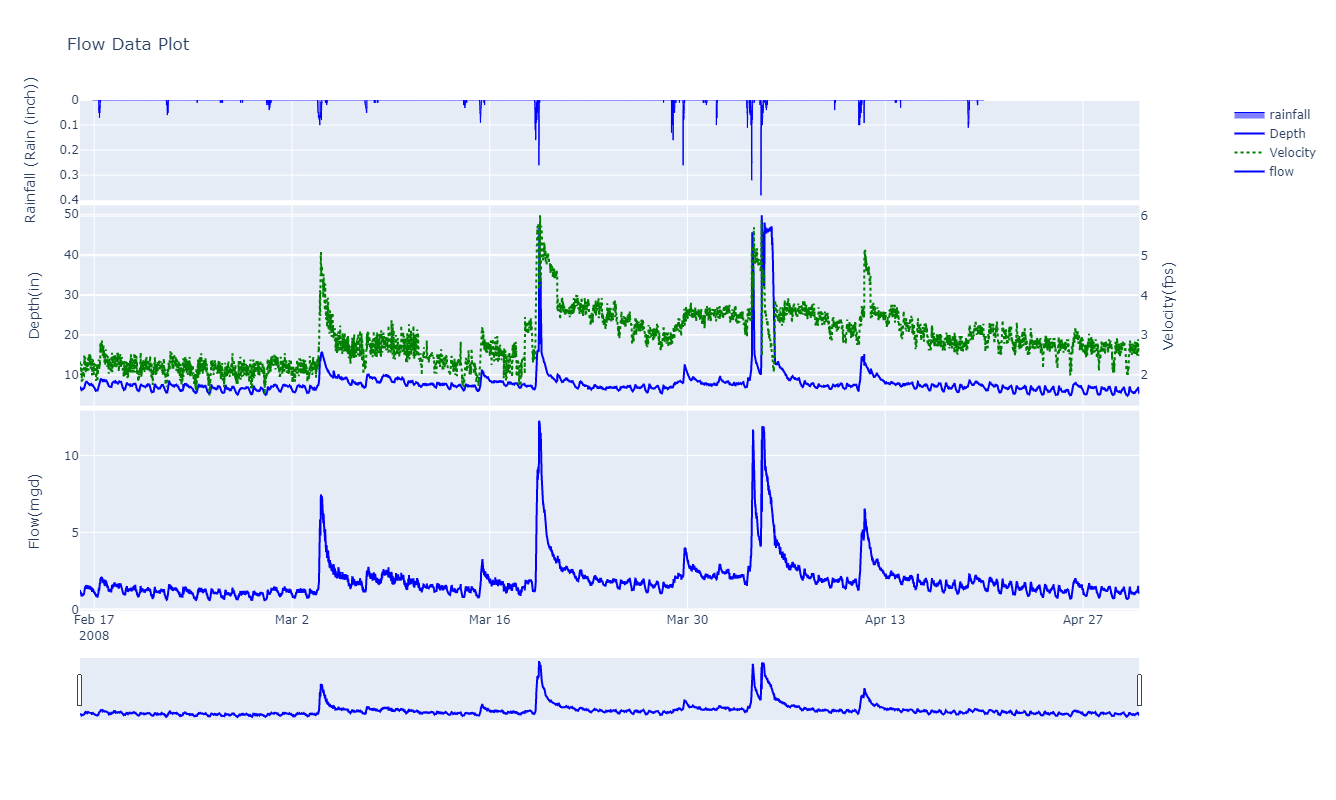

In [5]:
f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\dwf\data\Rain_Gauge.csv"
rain_df = read_rain_csv(f)
f = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\dwf\data\Flow_Monitor.csv"
flow_df = read_flow_csv(f)
flow_plot(flow_df, rain_df, depth_fld='Depth_in', velocity_fld='Velocity_fps', rainfall_fld='Rain (inch)', flow_fld='Flow_mgd', depth_unit='in', 
              rainfall_unit='in', flow_unit='mgd', velocity_unit='fps', start=None, end=None)

# Pick Dry Weather Days

When I started modeling, I had the very wrong idea about how things work. I thought modeling work should be done the same way I solve a physics problem, there is only one way to do it using the right equation, no matter who does it, it will give you the same results. 

Pretty quickly, I realized modeling especially sewer modeling with calibration data, is more like walking in a maze. It really doesn't matter that much exactly how you solved it, as long as you can get out that's all that matters. When it comes to modeling nobody knows how the real system works, so it is basically a maze to us, we are all making guesses one way or another.

If you share my view on modeling, you'll understnad my appoach to dry weather analysis. Instead of using the statisical analysis tools like the ones in SSOAP, I'll just eyeball it. Because I know if I got it wrong, I'll have very bad calibration results, and a good calibration is where I want to be, it doesn't matter how I start my guess.

Using the chart above, I got the following days as my dry weather days. 2/19-3/3/2008



# Plot Dry Weather Flow

I first plot the flow data to see if there are strong patterns. For the 13 days I selected, I can see a strong diurnal pattern, but not the same every day.

In [15]:
# need to get the day of the week first for weekday and weekend

df = flow_df.loc[:, ['Flow_mgd']]
df['dt'] = df.index
df['date'] = df['dt'].apply(lambda x: x.strftime('%y-%m-%d'))
df['dow'] = df['dt'].apply(lambda x: x.strftime('%a'))
df['weekend'] = df['dt'].apply(lambda x: x.strftime('%a') in ['Sun', 'Sat'])
df['wkno'] = df['dt'].apply(lambda x: x.strftime('%U'))
df['time'] = df['dt'].apply(lambda x: x.time())
start='2/19/2008 00:00'
end='3/3/2008 00:00'
df = df[start:end]

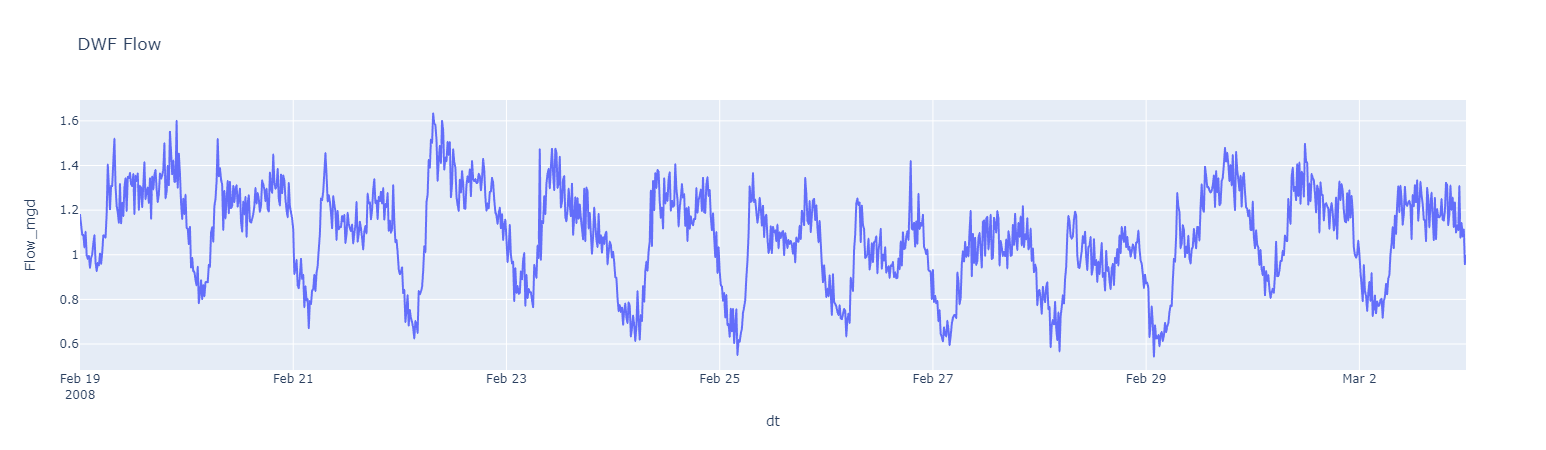

In [17]:
import plotly.express as px
fig = px.line(df, x='dt', y='Flow_mgd', title='DWF Flow')
fig.show()

In [14]:
# Let's what days are weekend
print(df.groupby(['date', 'dow']).count())

              Flow_mgd  dt  weekend  wkno  time
date     dow                                   
08-02-19 Tue        96  96       96    96    96
08-02-20 Wed        96  96       96    96    96
08-02-21 Thu        96  96       96    96    96
08-02-22 Fri        96  96       96    96    96
08-02-23 Sat        96  96       96    96    96
08-02-24 Sun        96  96       96    96    96
08-02-25 Mon        96  96       96    96    96
08-02-26 Tue        96  96       96    96    96
08-02-27 Wed        96  96       96    96    96
08-02-28 Thu        96  96       96    96    96
08-02-29 Fri        96  96       96    96    96
08-03-01 Sat        96  96       96    96    96
08-03-02 Sun        96  96       96    96    96
08-03-03 Mon         1   1        1     1     1


## Weekday vs Weekend

I generally use only weekday and weekend day hourly patterns for my models. For the purpose of master planning, the goal is not to get the model calibrated as closely as possible.Instead, it is to reasonably represent how the system work on a typical day of the week, it doesn't matter what day it is. So even if I cannot calibrate the results very well, as a modeler I'll need to make the decision what should a typical day look like even if there is no very strong patterns day after day.

When working on model calibration, decisions like this cannot be easily described as a formula. So if my wet weather response is much higher than my dry weather flow, then it makes no big difference. And if I don't have too much wet weather response, then I need to spend more time to decide if it worths the time to figure out if the spikes on certain days are some sort of industrial discharge, and maybe the utlility should figure out where it is from and work with the customer to understand what kind of impacts their operation might have on the system capacity.

The plot below, shows all the daily flows overlayed by weekday and weekend.

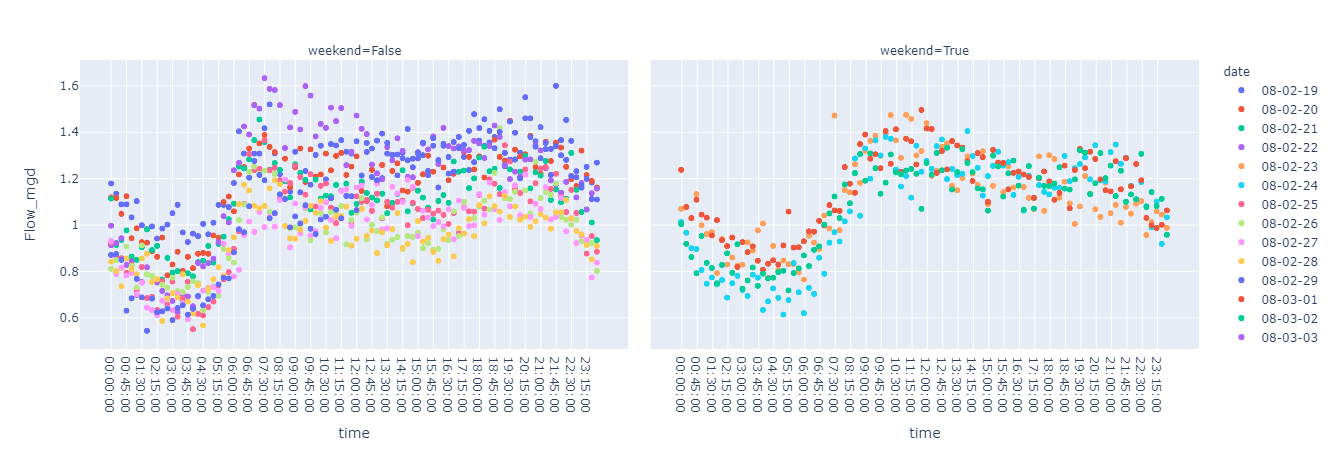

In [9]:
fig = px.scatter(df, x='time', y='Flow_mgd', 
                facet_col='weekend', 
                 color='date', facet_col_wrap=4)
fig.show()

As shown in the plot above.

We have roughtly two weeks worth of data, and there are 4 weekend days, and 9 days of weekday days.

- for weekdays, the variation is fairly high
- for weekend days, the variation is much smaller

We can plot the flow for each day of the week next to exam the data more closely


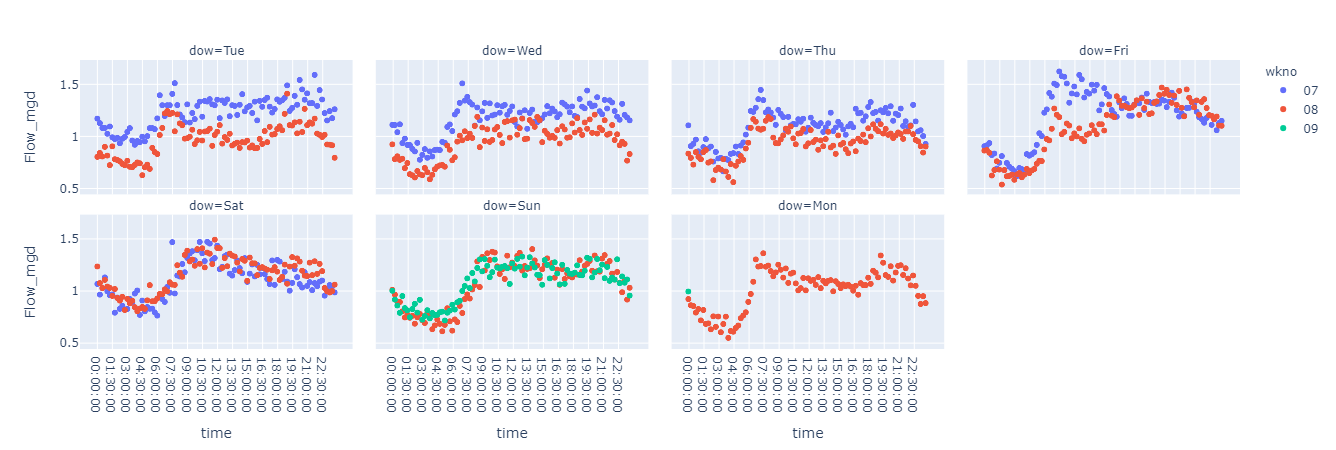

In [59]:
import plotly.express as px
fig = px.scatter(df, x='time', y='Flow_mgd', 
                facet_col='dow', 
                 color='wkno', facet_col_wrap=4)
fig.show()

As shown in the chart above, staturday and son day looks fine. But for week days, it looks like week 07 is in general has higher flow than week 08. And if we look at the whole data set, it does show fairly long tails after each storm event, so maybe week 07 is still under influence from a previous storm.